# Prelim

## Imports

*  "C1" = Cluster 1
*  "CP" = Cluster Prime Parameter
*  "FGM" = Flux Gate Magnetometer
*  "5VPS" = 5 vectors/second resolution
*  Skeleton table: https://spdf.gsfc.nasa.gov/pub/software/cdawlib/0SKELTABLES/c1_cp_fgm_5vps_00000000_v01.skt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import spacepy
from spacepy.coordinates import Coords
from spacepy.time import Ticktock

from time import strftime, localtime
from datetime import datetime
import pandas as pd

import os
import sys
from spacepy import pycdf

In [2]:
# Specify your directory containing the CDF files
cdf_directory = os.path.join('../Data/', '2020_Feb_Cluster/')

# Define the date range
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 3, 1)

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

R_E = 6370     # Cluster takes 1 earth radius to be 6370 km
R_E = 6378.137 # Spacepy takes 1 earth radius to be 6370 km 

### User friendly cdf functions

In [3]:
cdf = pycdf.CDF('C:/Users/joels/OneDrive - Lancaster University/Academic/Lancaster/Project/Work/Coding/Data/2020_Feb_Cluster/C1_CP_FGM_5VPS__20200101_000000_20200102_000000_V210330.cdf')

In [4]:
print(cdf)

B_mag__C1_CP_FGM_5VPS: CDF_FLOAT [432000]
B_vec_xyz_gse__C1_CP_FGM_5VPS: CDF_FLOAT [432000, 3]
B_vec_xyz_gse__C1_CP_FGM_5VPS_LABEL_1: CDF_CHAR*2 [3] NRV
B_vec_xyz_gse__C1_CP_FGM_5VPS_REPRESENTATION_1: CDF_CHAR*1 [3] NRV
half_interval__C1_CP_FGM_5VPS: CDF_FLOAT [432000]
range__C1_CP_FGM_5VPS: CDF_INT4 [432000]
sc_pos_xyz_gse__C1_CP_FGM_5VPS: CDF_FLOAT [432000, 3]
sc_pos_xyz_gse__C1_CP_FGM_5VPS_LABEL_1: CDF_CHAR*1 [3] NRV
sc_pos_xyz_gse__C1_CP_FGM_5VPS_REPRESENTATION_1: CDF_CHAR*1 [3] NRV
time_tags__C1_CP_FGM_5VPS: CDF_EPOCH [432000]
tm__C1_CP_FGM_5VPS: CDF_INT4 [432000]


In [5]:
print(cdf['time_tags__C1_CP_FGM_5VPS'][...])

[datetime.datetime(2020, 1, 1, 0, 0, 0, 100000)
 datetime.datetime(2020, 1, 1, 0, 0, 0, 300000)
 datetime.datetime(2020, 1, 1, 0, 0, 0, 500000) ...
 datetime.datetime(2020, 1, 1, 23, 59, 59, 500000)
 datetime.datetime(2020, 1, 1, 23, 59, 59, 700000)
 datetime.datetime(2020, 1, 1, 23, 59, 59, 900000)]


In [6]:
print(cdf['B_vec_xyz_gse__C1_CP_FGM_5VPS'][...])

[[ -7.552  12.531  -3.687]
 [ -7.469  12.542  -3.571]
 [ -7.452  12.391  -3.569]
 ...
 [-89.251   8.319 141.047]
 [-89.231   8.257 141.018]
 [-89.237   8.462 141.022]]


## Definitions

### Data Handling Functions

In [7]:
def open_cdfs_in_date_range(directory, start_date, end_date):
    """
    Filters cdf files in a given directory based on a specified date range.

    Parameters
    ----------
    directory : str
        The path to the directory containing the cdf files.
        
    start_date : datetime
        The starting date of the range for which files should be selected.
        
    end_date : datetime
        The ending date of the range for which files should be selected.

    Returns
    -------
    list of str :
        A list of file paths for cdf files whose dates fall within the specified range.
    """
    cdf_files = []
    for file in os.listdir(directory):
        if file.endswith('.cdf'):
            # Assuming filename is data-name__dates_version.cdf
            date_str = file.split('__')[1][:8]  # Get the first 8 characters after '__' (YYYYMMDD)
            file_date = datetime.strptime(date_str, '%Y%m%d')
            
            # Check if file_date is within the date range
            if start_date <= file_date <= end_date:
                cdf_files.append(os.path.join(cdf_directory, file))
    
    return cdf_files

In [8]:
def extract_cdf_data(cdf_file, variables):
    """
    Loads specified variables from a CDF file and returns a dictionary with extracted data.

    Parameters
    ----------
    cdf_file : str
        The path to the CDF file.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
    dict :
        A dictionary where keys are variable names, and values are the corresponding data arrays.
    """
    
    # Initialise a dictionary to store the data
    data_dict = {}

    # Load the CDF file (auto closes)
    with pycdf.CDF(cdf_file) as cdf:
    
        # Loop through the dictionary of variables and extract data
        for var_name, var_code in variables.items():
            data = cdf[var_code][...]  # Extract the data using the CDF variable code
            
            # Handle vector data
            if data.ndim == 2:  # Assuming a 2D array for vector components (e.g. Nx3 for 3D vectors)
                if var_name == 'r':
                    data /= R_E # scales distances to multiple of Earth radii
                    
                data_x = data[:, 0]
                data_y = data[:, 1]
                data_z = data[:, 2]
                
                # Calculate the magnitude of the vector
                data_dict[f'{var_name}_mag'] = np.linalg.norm(data, axis=1)
                
                # Split into components (e.g. x, y, z)
                data_dict[f'{var_name}_x_GSE'] = data_x
                data_dict[f'{var_name}_y_GSE'] = data_y
                data_dict[f'{var_name}_z_GSE'] = data_z
            # Scalar data
            else:
                # Store the data in the dictionary with the desired variable name
                data_dict[var_name] = data # pycdf extracts as datetime - no conversion from epoch needed
    
    return data_dict

In [9]:
def process_cdf_files(cdf_files, variables):
    """
    Processes a list of CDF files and extracts the specified variables, returning a pandas DataFrame.

    Parameters
    ----------
    cdf_files : list of str
        List of paths to the CDF files to be processed.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
    pandas.DataFrame : one column for each variable :
        A DataFrame containing the extracted data from the CDF files, with scalar variables as columns,
        vector components as separate columns, and the magnitude of vectors.
    """
    # Initialise an empty DataFrame
    df = pd.DataFrame()

    # Loop through each CDF file and extract data
    for cdf_file in cdf_files:
        
        # Load the data for the specified variables
        data_dict = extract_cdf_data(cdf_file, variables)

        try:
            # Convert the data_dict to a DataFrame for this file
            file_df = pd.DataFrame(data_dict)
            
            # Append the file's DataFrame to the main DataFrame
            df = pd.concat([df, file_df], ignore_index=True)
            
        except ValueError as ve:
            print(cdf_file)
            
    return df

In [10]:
def segment_dataframe(df, column='t', delta='200ms'):
    """
    Adds a 'segment' column to the DataFrame based on time gaps exceeding a threshold, (for plotting purposes).
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing data to be segmented.
    column : str
        The name of the column with time values.
    delta : str or pd.Timedelta
        The time gap threshold for segmenting data.

    Returns
    -------
        None - the procedure modifies the input DataFrame in place.
    """

    # Ensure delta is a Timedelta object
    time_threshold = pd.Timedelta(delta)
    
    # Calculate the time differences between consecutive rows
    time_diffs = df[column].diff()

    # Create the 'segment' column in a single operation
    df.insert(0, 'segment', (time_diffs > time_threshold).cumsum())

### Calculation Functions

In [11]:
def convert_coords(df, param='r', coords='GSM', geom='car'):
    key = param + '_x_' + coords
    if key not in df.keys():
        vectors = df[[param+'_x_GSE', param+'_y_GSE', param+'_z_GSE']].values
        
        times = df['t'].tolist()
        tickings = Ticktock(times, 'UTC')
        
        gses = Coords(vectors, 'GSE', 'car')
        gses.ticks = tickings
        
        gsms = gses.convert(coords, geom).data
        
        keys = list(df.keys())
        index = keys.index(param+'_z_GSE')
        
        # Insert the new columns
        df.insert(index+1, param+'_x_'+coords, gsms[:,0])
        df.insert(index+2, param+'_y_'+coords, gsms[:,1])
        df.insert(index+3, param+'_z_'+coords, gsms[:,2])

### Plotting Functions

In [12]:
def plot_orbit_components(df, coords='GSE'):
    
    convert_coords(df, coords=coords)
    
    fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})
    fig.suptitle(f'Orbit data from {start_date_str} to {end_date_str} in {coords}', fontsize=18)
    plt.tight_layout()

    for _, segment in df.groupby('segment'):
        axs[0].plot(segment['t'], segment['r_x_'+coords], c='b', lw=0.5)
        axs[1].plot(segment['t'], segment['r_y_'+coords], c='b', lw=0.5)
        axs[2].plot(segment['t'], segment['r_z_'+coords], c='b', lw=0.5)
        axs[3].plot(segment['t'], segment['r_mag'], c='r', lw=0.5)

    # Add labels
    plt.xlabel(r'time', fontsize=16) # or axs[2].set_xlabel

    # Format the x-axis to display full dates and times with more detail
    # "Hour:Minute:Second // Year-Month-Day"
    date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
    axs[2].xaxis.set_major_formatter(date_format)

    axs[0].set_ylabel(r'$r_x$ [$R_E$]', fontsize=16)
    axs[1].set_ylabel(r'$r_y$ [$R_E$]', fontsize=16)
    axs[2].set_ylabel(r'$r_z$ [$R_E$]', fontsize=16)
    axs[3].set_ylabel(r'$r$ [$R_E$]', fontsize=16);

    #plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

In [13]:
def plot_orbit(df,x_axis='r_x',y_axis='r_y',coords='GSE'):
    
    convert_coords(df, coords=coords)
    
    fig, ax = plt.subplots(figsize=(8,6))
    fig.suptitle(f'Orbit data from {start_date_str} to {end_date_str} in {coords}', fontsize=18)

    plt.grid(linestyle='--', lw=0.5)
    
    x_label = x_axis + '_' + coords
    y_label = y_axis + '_' + coords
    
    x0 = df[x_label][0]
    y0 = df[y_label][0]

    # Add small cross at the start point
    ax.scatter(x0, y0, color='orange', marker='x', s=100)

    # Add Earth
    plt.scatter(0, 0, color='blue', marker='o', s=600)

    for _, segment in df.groupby('segment'):
        # Plot ry against rx to see orbit in x-y plane
        ax.plot(segment[x_label], segment[y_label], c='b', lw=0.5)

    # Add arrows to indicate direction
    for i in np.linspace(50, len(df[x_label]) - 2, 20):
        i=int(i)
        xi  = df[x_label][i]   ; yi  = df[y_label][i]
        xi1 = df[x_label][i+1] ; yi1 = df[y_label][i+1]

        ax.arrow(xi, yi, xi1 - xi, yi1 - yi,
             head_width=.3, head_length=.4, fc='red', ec='red')

    # Add labels
    plt.xlabel(f'${x_axis}$ [$R_E$] ({coords})', fontsize=16)
    if x_axis == 'r_x' or x_axis == 'r_y':
        plt.gca().invert_xaxis()
    
    plt.ylabel(f'${y_axis}$ [$R_E$] ({coords})', fontsize=16)
    if y_axis == 'r_x' or y_axis == 'r_y':
        plt.gca().invert_yaxis()

    #plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

In [14]:
def plot_heat_map(df,x_axis='r_x',y_axis='r_y',coords='GSE',z_limits=None,bin_size=1,weight=False):
    """
    Procedure to plot a heat map of the orbit of the satellite in a 2D plane, (x-y).
    Arguments can be adjusted for the pixel size and whether to constrain when close to z=0 or not.

    Parameters
    ----------
    xs : pandas.Series
        The satellite's orbit coordinates plotted on the x-axis.
        
    ys : pandas.Series
        The satellite's orbit coordinates plotted on the y-axis.
        
    zs : pandas.Series
        The satellite's orbit coordinates not plotted but counted through for the density profile.
        
    z_limits : tuples of 2 values : optional :
        Lower and upper limit for the values for the satellite in the z-plane.
        By default is None, (takes all values in z-plane).
        
    bin-size : int : optional
        Size of the pixels/bins for the heat map.
        By default is 1 (RE).

    weight : Boolean : optional
        Whether to weigh the histogram to display the legend in number of data points (default/False),
        or to weigh and display in minutes (True).

    Returns
    -------
        None : procedure just plots a figure.
    """
    convert_coords(df, coords=coords)
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    x_label = x_axis + '_' + coords
    y_label = y_axis + '_' + coords
    
    labels=['r_x','r_y','r_z']
    try:
        labels.remove(x_axis)
    except NameError:
        print("Invalid choice for x-axis")
    else:
        try:
            labels.remove(y_axis)
        except NameError:
            print("Invalid choice for y-axis")
    finally:
        z_label = labels[0] + '_' + coords
    
    # Calculate the number of bins based on the range of data and the bin size
    x_min, x_max = np.floor(df[x_label].min()), np.ceil(df[x_label].max())
    y_min, y_max = np.floor(df[y_label].min()), np.ceil(df[y_label].max())
    
    # Create bins starting from 0, with bin edges aligned to (0, 0)
    x_bins = np.arange(x_min, x_max + bin_size, bin_size) 
    y_bins = np.arange(y_min, y_max + bin_size, bin_size)

    # If no limits are passed in for z, use full data range
    if z_limits is None:
        z_min, z_max = np.floor(df[z_label].min()), np.ceil(df[z_label].max())
    else:
        z_min, z_max = z_limits[0], z_limits[1]
    
    # Masking data within z range
    mask = (df[z_label] >= z_min) & (df[z_label] <= z_max)

    # Create weights to display color bar
    c_label = 'Number of Points'
    weights = np.ones_like(df[x_label][mask])
    # Weighs the density values to display in minutes, assuming data 200ms apart
    if weight:
        weights /= 3000
        c_label = 'Minutes'
    
    # Create the 2D histogram (heatmap)
    plt.hist2d(df[x_label][mask], df[y_label][mask], 
               bins=[x_bins, y_bins], weights=weights, cmap='hot')
    plt.colorbar(label=c_label)
    
    # Add Earth
    plt.scatter(0, 0, color='blue', marker='o', s=600)
  
    # Set the x and y ticks to every 1 unit
    plt.xticks(np.arange(x_min, x_max + 1, 1))
    plt.yticks(np.arange(y_min, y_max + 1, 1))
    
    fig.suptitle(f'Orbit data from {start_date_str} to {end_date_str} in {coords}\n where {z_min}$R_E$ $\\leq${z_label[2]}$\\leq${z_max} $R_E$', fontsize=18)

    # Add labels
    plt.xlabel(f'${x_axis}$ [$R_E$] ({coords})', fontsize=16)
    if x_axis == 'r_x' or x_axis == 'r_y':
        plt.gca().invert_xaxis()
    
    plt.ylabel(f'${y_axis}$ [$R_E$] ({coords})', fontsize=16)
    if y_axis == 'r_x' or y_axis == 'r_y':
        plt.gca().invert_yaxis()

## Extract Data

In [15]:
# List of paths to the files within the desired date range
cdf_files = open_cdfs_in_date_range(cdf_directory, start_date, end_date)

In [16]:
variables = {
    't' : 'time_tags__C1_CP_FGM_5VPS',     # extracts the epoch time in milliseconds (scalar).
    #'B' : 'B_vec_xyz_gse__C1_CP_FGM_5VPS' # extracts the fgm data in nT (vector).
    'r' : 'sc_pos_xyz_gse__C1_CP_FGM_5VPS' # extracts the position in km from centre of Earth (vector).
}

In [17]:
# Process the CDF files and extract the data into a pandas DataFrame
df_fgm = process_cdf_files(cdf_files, variables)
segment_dataframe(df_fgm)

../Data/2020_Feb_Cluster/C1_CP_FGM_5VPS__20200126_000000_20200127_000000_V210607.cdf
../Data/2020_Feb_Cluster/C1_CP_FGM_5VPS__20200225_000000_20200226_000000_V210729.cdf


In [18]:
# Display the first/last few rows of the DataFrame
#print(df_fgm.head())
#print(df_fgm.tail())

# Main

## Coordinate Transformations

*  GSE - Coordinates
*  car/sph - cartesian/spherical
*  Default in RE

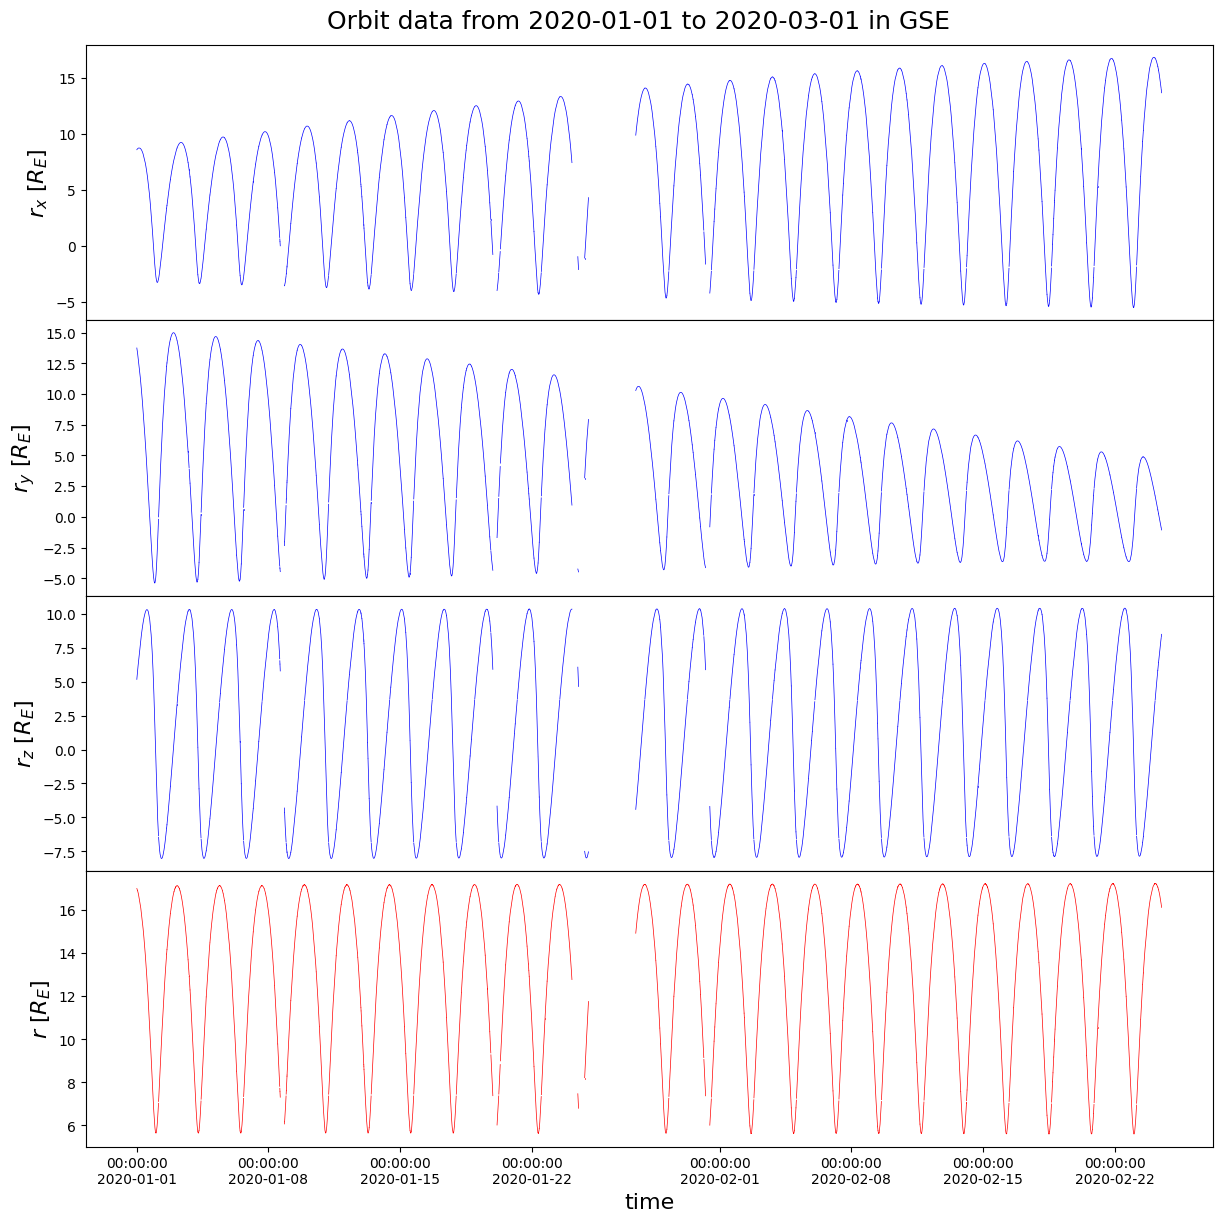

In [19]:
plot_orbit_components(df_fgm, coords='GSE')

In [ ]:
plot_orbit_components(df_fgm, coords='GSM')

In [ ]:
plot_orbit(df_fgm, x_axis='r_x', y_axis='r_y', coords='GSE')

In [ ]:
plot_orbit(df_fgm, x_axis='r_x', y_axis='r_y', coords='GSM')

In [ ]:
plot_orbit(df_fgm, x_axis='r_x', y_axis='r_z', coords='GSE')

In [ ]:
plot_orbit(df_fgm, x_axis='r_x', y_axis='r_z', coords='GSM')

In [ ]:
plot_heat_map(df_fgm, x_axis='r_x', y_axis='r_y', coords='GSE', z_limits=None, bin_size=1, weight=False)

In [ ]:
plot_heat_map(df_fgm, x_axis='r_x', y_axis='r_y', coords='GSM', z_limits=None, bin_size=1, weight=False)

In [ ]:
with cdf.CDF('2020_Feb_Processed.cdf', '') as cdf_file:
    for key, data df_fgm.items():
        cdf[key] = data
    
    cdf.attrs['Author'] = 'Joel Richardson'
    cdf.attrs['CreateDate'] = datetime.datetime.now()
    cdf['r_x_GSE'].attrs['units'] = 'Re'